In [687]:
import math
import numpy as np
import os

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

sns.set()
sns.set_style("ticks")
sns.set_context("paper")
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [688]:
three_d_points = np.array([
    [-0.080903, -2.30455, 1.19694],  # Top right solar panel
    [-0.157453, -0.843874, 1.19694],  # Top left solar panel
    [-0.080903, -2.30455, -0.783056],  # Bottom right solar panel
    [-0.157453, -0.843874, -0.783056],  # Bottom left solar panel
    [-0.244135, 1.03251, -0.65297],  # Bottom left satellite
])

# three_d_points_extra = three_d_points - np.array([0.2799, -0.1329, -0.1785])

three_d_points_names = [
    'Top right solar panel',
    'Top left solar panel',
    'Bottom right solar panel',
    'Bottom left solar panel',
    'Bottom left satellite'
]


def get_normalized_rotation(roll, pitch, yaw):
    roll_rotation_axis = -19.4321
    pitch_rotation_axis = 0
    yaw_rotation_axis = 179.9654
    r_roll_rotation_axis = np.array([[1, 0, 0],
                                     [0, math.cos(roll_rotation_axis / 180 * math.pi),
                                      -math.sin(roll_rotation_axis / 180 * math.pi)],
                                     [0, math.sin(roll_rotation_axis / 180 * math.pi),
                                      math.cos(roll_rotation_axis / 180 * math.pi)]])

    r_pitch_rotation_axis = np.array(
        [[math.cos(pitch_rotation_axis / 180 * math.pi), 0, math.sin(pitch_rotation_axis / 180 * math.pi)],
         [0, 1, 0],
         [-math.sin(pitch_rotation_axis / 180 * math.pi), 0, math.cos(pitch_rotation_axis / 180 * math.pi)]])

    r_yaw_rotation_axis = np.array(
        [[math.cos(yaw_rotation_axis / 180 * math.pi), -math.sin(yaw_rotation_axis / 180 * math.pi), 0],
         [math.sin(yaw_rotation_axis / 180 * math.pi), math.cos(yaw_rotation_axis / 180 * math.pi), 0],
         [0, 0, 1]])

    rotation_matrix_rotation_axis = r_yaw_rotation_axis @ r_pitch_rotation_axis @ r_roll_rotation_axis

    r_roll = np.array([[1, 0, 0],
                       [0, math.cos(roll / 180 * math.pi), -math.sin(roll / 180 * math.pi)],
                       [0, math.sin(roll / 180 * math.pi), math.cos(roll / 180 * math.pi)]])

    r_pitch = np.array([[math.cos(pitch / 180 * math.pi), 0, math.sin(pitch / 180 * math.pi)],
                        [0, 1, 0],
                        [-math.sin(pitch / 180 * math.pi), 0, math.cos(pitch / 180 * math.pi)]])

    r_yaw = np.array([[math.cos(yaw / 180 * math.pi), -math.sin(yaw / 180 * math.pi), 0],
                      [math.sin(yaw / 180 * math.pi), math.cos(yaw / 180 * math.pi), 0],
                      [0, 0, 1]])

    rotation_matrix = (r_yaw @ r_pitch @ r_roll)

    roll = np.rad2deg(math.atan2(rotation_matrix[2, 1], rotation_matrix[2, 2]))
    pitch = np.rad2deg(
        math.atan2(-rotation_matrix[2, 0],
                   math.sqrt(rotation_matrix[2, 1] ** 2 + rotation_matrix[2, 2] ** 2)))
    yaw = np.rad2deg(
        math.atan2(rotation_matrix[1, 0], rotation_matrix[0, 0]))

    return roll, pitch, yaw


def get_pixel_coordinates(x, y, z):
    mm = 1e-3
    um = 1e-6
    f = 20 * mm

    # world coordinates to image coordinates
    point2d_rotated = np.zeros((3, 1))
    x_2d = x / (22 + z) * f / (8.6 * um)
    y_2d = y / (22 + z) * f / (8.6 * um)

    return x_2d, y_2d


def get_rotated_point(roll, pitch, yaw, point=None):
    if point is None:
        point = [-0.08, -2.30333333, 1.19666667]

    r_roll = np.array([[1, 0, 0],
                       [0, math.cos(roll / 180 * math.pi), -math.sin(roll / 180 * math.pi)],
                       [0, math.sin(roll / 180 * math.pi), math.cos(roll / 180 * math.pi)]])

    r_pitch = np.array([[math.cos(pitch / 180 * math.pi), 0, math.sin(pitch / 180 * math.pi)],
                        [0, 1, 0],
                        [-math.sin(pitch / 180 * math.pi), 0, math.cos(pitch / 180 * math.pi)]])

    r_yaw = np.array([[math.cos(yaw / 180 * math.pi), -math.sin(yaw / 180 * math.pi), 0],
                      [math.sin(yaw / 180 * math.pi), math.cos(yaw / 180 * math.pi), 0],
                      [0, 0, 1]])

    rotation_matrix = r_yaw @ r_pitch @ r_roll

    rotated_3d_points = np.dot(rotation_matrix, point)

    return rotated_3d_points

In [689]:
folder = "../test_images/replica_of_dynamic_unknowndeg_0to360_5degstep/"
suffix = '_synthetic_noLineFit'
# folder = "../test_images/dynamic_unknowndeg_0to360_5degstep/"
# suffix = '_eps2_final_strict'
colors = ['red', 'green', 'blue']
normalize = True

In [690]:
import subprocess

In [691]:
def to_latex_table(df, caption, label, decimal=3):
    text = df.to_latex(index=False, escape=True,
                       caption=caption,
                       label=label, float_format=f'%.{decimal}f',
                       position="h", longtable=True)
    subprocess.run("pbcopy", text=True, input=text)



In [692]:
df_true = pd.read_csv(folder + "real_scores.csv")
df_true = df_true.rename(columns={'real_roll': 'roll', 'real_pitch': 'pitch', 'real_yaw':
    'yaw'})
# if normalize:
#     df_true['roll'], df_true['pitch'], df_true['yaw'] = np.vectorize(get_normalized_rotation)(df_true['roll'],
#                                                                                               df_true['pitch'],
#                                                                                               df_true['yaw'])
df_true['img_number'] = df_true.index
# drop first image
df_true = df_true.drop(df_true.index[0])

In [693]:
# to_latex_table(df_true, 'True scores', 'true_scores')

In [694]:
df_guess = pd.read_csv(folder + "guesses" + suffix + ".csv")
# drop first image
df_guess = df_guess.drop(df_guess.index[0])
# if normalize:
#     df_guess['roll'], df_guess['pitch'], df_guess['yaw'] = np.vectorize(get_normalized_rotation)(df_guess['roll'],
#                                                                                                  df_guess['pitch'],
#                                                                                                  df_guess['yaw'])
#     df_guess['roll_min'], df_guess['pitch_min'], df_guess['yaw_min'] = np.vectorize(get_normalized_rotation)(
#         df_guess['roll_min'],
#         df_guess['pitch_min'],
#         df_guess['yaw_min'])
#     df_guess['roll_max'], df_guess['pitch_max'], df_guess['yaw_max'] = np.vectorize(get_normalized_rotation)(
#         df_guess['roll_max'],
#         df_guess['pitch_max'],
#         df_guess['yaw_max'])

In [695]:
# to_latex_table(df_guess, 'Guesses', 'guesses', 3)

In [696]:
df = pd.read_csv(folder + "fine_scores" + suffix + ".csv")
# drop first image
df = df.drop(df.index[0])
if normalize:
    df['roll'], df['pitch'], df['yaw'] = np.vectorize(get_normalized_rotation)(df['roll'],
                                                                               df['pitch'],
                                                                               df['yaw'])

In [697]:
to_latex_table(df, 'Fine scores', 'fine_scores', 3)

In [698]:
df_rough = pd.read_csv(folder + "best_scores.csv")
# drop first image
df_rough = df_rough.drop(df_rough.index[0])
df_rough['img_number'] = df_rough['file_name']
if normalize:
    df_rough['roll'], df_rough['pitch'], df_rough['yaw'] = np.vectorize(get_normalized_rotation)(df_rough['roll'],
                                                                                                 df_rough['pitch'],
                                                                                                 df_rough['yaw'])

<Axes: xlabel='img_number', ylabel='x'>

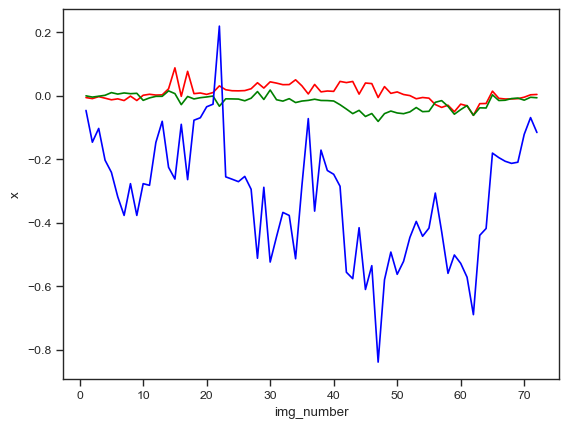

In [699]:
sns.lineplot(df, x='img_number', y='x', ci=None, color='red')
sns.lineplot(df, x='img_number', y='y', ci=None, color='green')
sns.lineplot(df, x='img_number', y='z', ci=None, color='blue')

In [700]:
def plot_guess(guess_type, df=df_guess):
    sns.lineplot(data=df, x='img_number', y=guess_type, color='blue', ci=None)
    sns.lineplot(data=df, x='img_number', y=guess_type + '_min', color='red', ci=None)
    sns.lineplot(data=df, x='img_number', y=guess_type + '_max', color='green', ci=None)
    sns.scatterplot(data=df, x='img_number', y=guess_type, color='black')
    plt.legend(['Guess', 'Min', 'Max', 'Lowest loss estimate'])
    plt.title('SMA ' + guess_type + ' guesses')
    plt.xlabel('Image number')
    if guess_type in ['roll', 'pitch', 'yaw']:
        plt.ylabel(guess_type + ' (deg)')

    else:
        plt.ylabel(guess_type + ' (m)')

    plt.savefig(folder + "plots/" + guess_type + '_guesses' + suffix + '.png')
    plt.show()

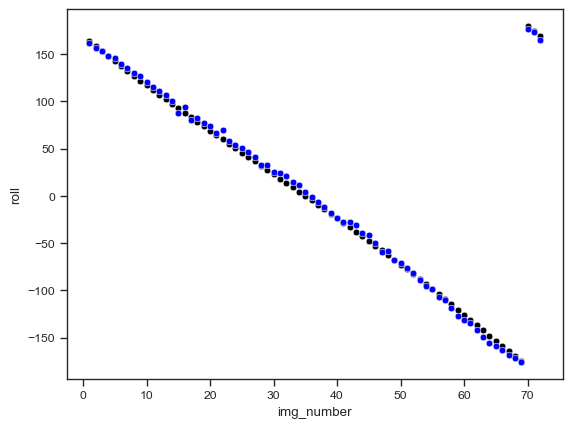

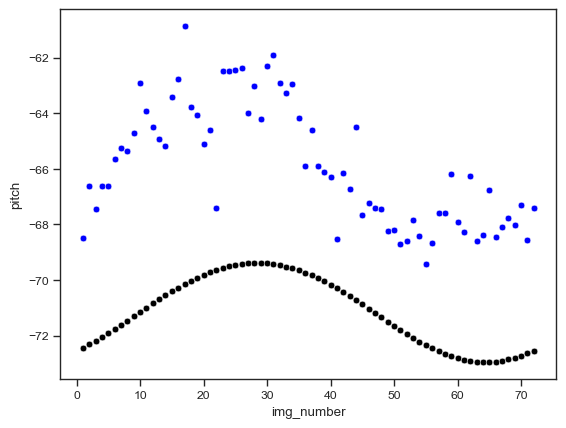

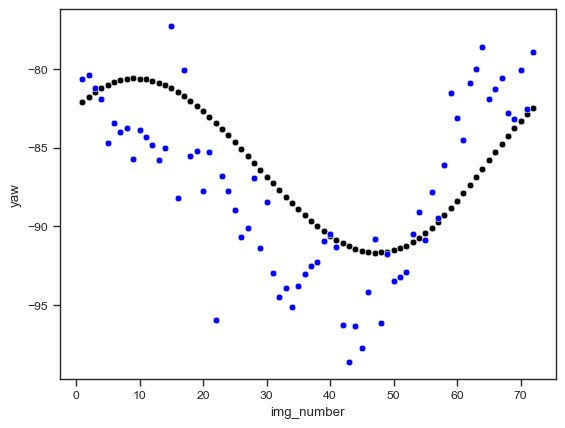

In [701]:
for guess_type in ['roll', 'pitch', 'yaw']:
    sns.scatterplot(data=df_true, x='img_number', y=guess_type, color='black')
    sns.scatterplot(data=df, x='img_number', y=guess_type, color='blue')
    # sns.scatterplot(data=df_rough, x='img_number', y=guess_type, color='green')
    plt.show()

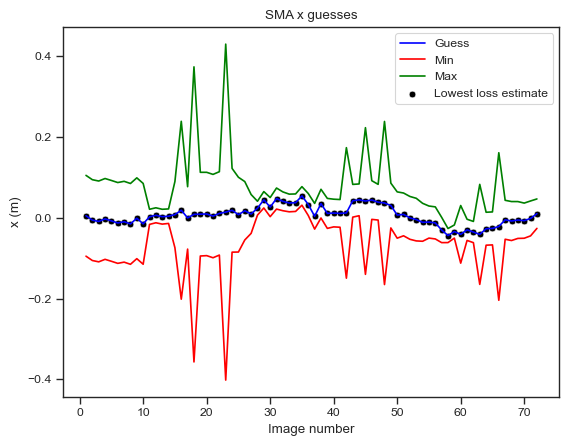

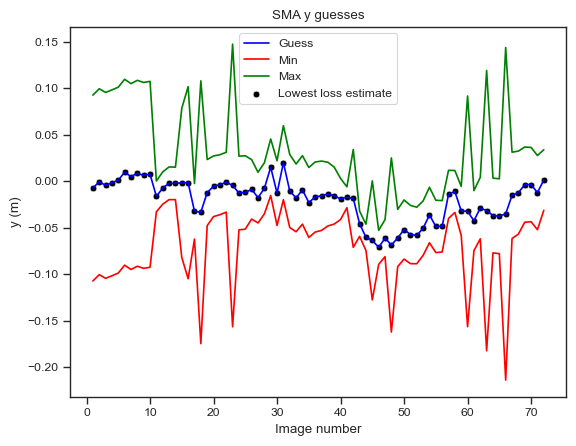

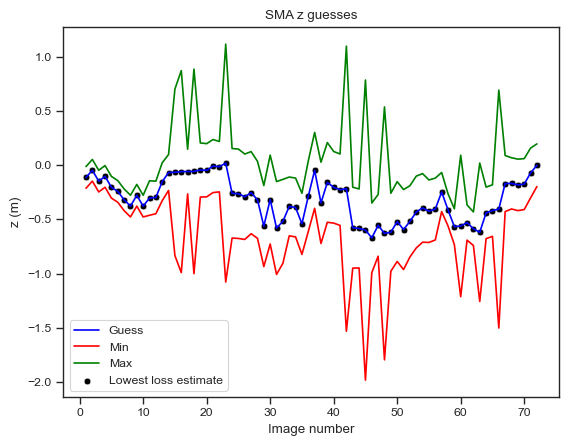

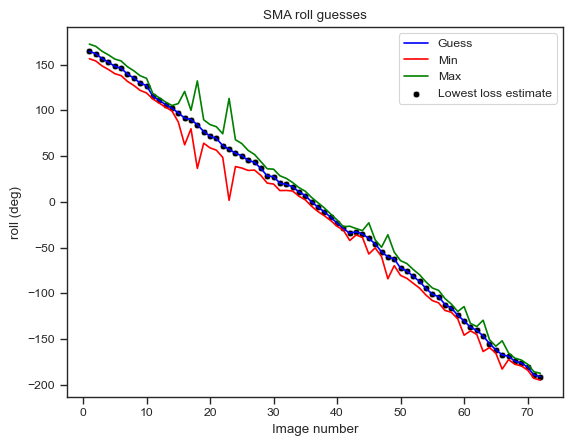

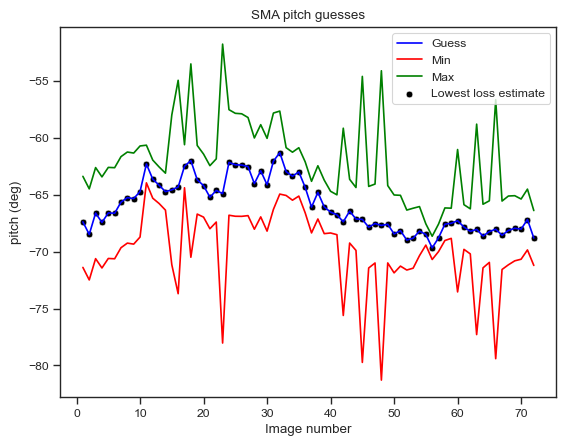

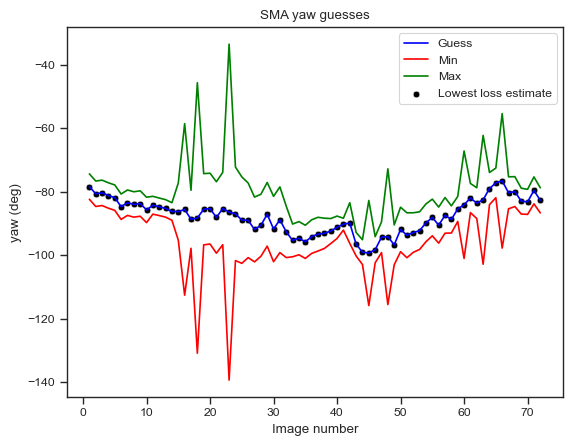

In [702]:
for guess_type in ['x', 'y', 'z', 'roll', 'pitch', 'yaw']:
    plot_guess(guess_type)

In [703]:
def plot_translation(trans_type):
    sns.scatterplot(data=df, x='img_number', y=trans_type, color='black')
    mean = df[trans_type].mean()
    plt.axhline(mean, color='red', linestyle='dashed', linewidth=1)
    std = df[trans_type].std()
    plt.axhline(mean + std, color='green', linestyle='dashed', linewidth=1)
    plt.axhline(mean - std, color='green', linestyle='dashed', linewidth=1)
    plt.title(trans_type + ' estimates for CoM')
    plt.xlabel('Image number')
    plt.ylabel(trans_type + ' (m)')
    plt.legend([trans_type + ' estimates', 'Mean', 'Standard deviation'])
    plt.show()

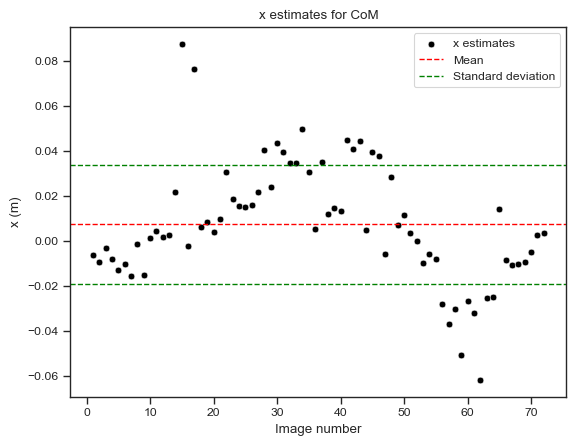

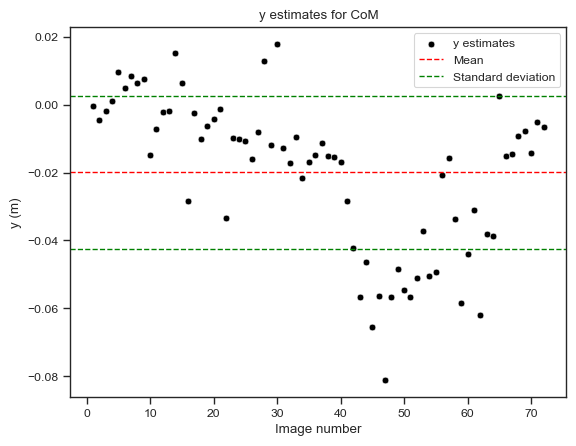

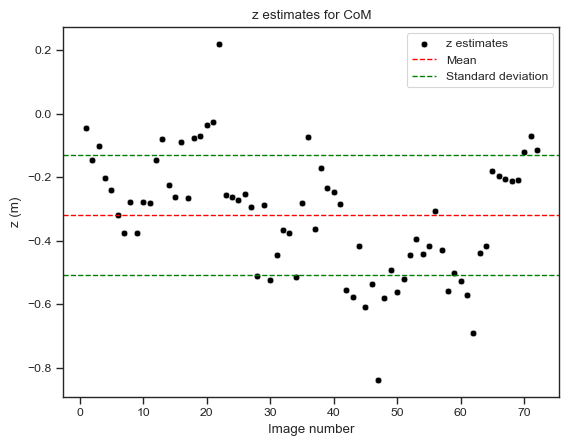

In [704]:
for i in ['x', 'y', 'z']:
    plot_translation(i)

In [705]:
df_rotated_points_true = pd.DataFrame()
for i, point in enumerate(three_d_points):
    df_local = df_true.apply(
        lambda row: get_rotated_point(row['roll'], row['pitch'], row['yaw'], point),
        axis=1, result_type='expand').rename(columns={0: 'x_point', 1: 'y_point', 2: 'z_point'})
    df_local['img_number'] = df_true['img_number']
    df_local['3d_point'] = three_d_points_names[i]
    df_rotated_points_true = pd.concat([df_local, df_rotated_points_true])

In [706]:
df_rotated_points_true = df_rotated_points_true.merge(df_true, on='img_number')

In [707]:
df_rotated_points = pd.DataFrame()
for i, point in enumerate(three_d_points):
    df_local = df.apply(
        lambda row: get_rotated_point(row['roll'], row['pitch'], row['yaw'], point),
        axis=1, result_type='expand').rename(columns={0: 'x_point', 1: 'y_point', 2: 'z_point'})
    df_local['img_number'] = df['img_number']
    df_local['3d_point'] = three_d_points_names[i]
    df_rotated_points = pd.concat([df_local, df_rotated_points])
# df_rotated_points.to_csv(folder + 'rotated_points.csv')

In [708]:
df_rotated_points = df_rotated_points.merge(df, on='img_number')

In [709]:
df_rotated_points_rough = pd.DataFrame()
for i, point in enumerate(three_d_points):
    df_local = df_rough.apply(
        lambda row: get_rotated_point(row['roll'], row['pitch'], row['yaw'], point),
        axis=1, result_type='expand').rename(columns={0: 'x_point', 1: 'y_point', 2: 'z_point'})
    df_local['img_number'] = df_rough['img_number']
    df_local['3d_point'] = three_d_points_names[i]
    df_rotated_points_rough = pd.concat([df_local, df_rotated_points_rough])

In [710]:
df_rotated_points

,x_point,y_point,z_point,img_number,3d_point,iterations,loss,roll,pitch,yaw,x,y,z
0,-0.927040,0.823939,0.117345,1,Bottom left satellite,0,0.058101,162.047951,-68.488490,-80.657160,-0.005982,-0.000509,-0.046545
1,0.947694,0.671556,0.031297,1,Bottom left solar panel,0,0.058101,162.047951,-68.488490,-80.657160,-0.005982,-0.000509,-0.046545
2,2.391378,0.456148,-0.062572,1,Bottom right solar panel,0,0.058101,162.047951,-68.488490,-80.657160,-0.005982,-0.000509,-0.046545
3,0.630000,-1.156666,-0.659396,1,Top left solar panel,0,0.058101,162.047951,-68.488490,-80.657160,-0.005982,-0.000509,-0.046545
4,2.073684,-1.372075,-0.753266,1,Top right solar panel,0,0.058101,162.047951,-68.488490,-80.657160,-0.005982,-0.000509,-0.046545
...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,-0.989901,0.746902,0.119504,72,Bottom left satellite,0,0.681237,164.999431,-67.411841,-78.945309,0.003833,-0.006605,-0.115971
356,0.892075,0.741985,0.061256,72,Bottom left solar panel,0,0.681237,164.999431,-67.411841,-78.945309,0.003833,-0.006605,-0.115971
357,2.349366,0.641075,-0.013283,72,Bottom right solar panel,0,0.681237,164.999431,-67.411841,-78.945309,0.003833,-0.006605,-0.115971
358,0.727692,-1.089330,-0.673354,72,Top left solar panel,0,0.681237,164.999431,-67.411841,-78.945309,0.003833,-0.006605,-0.115971


In [711]:
df_rotated_points_rough = df_rotated_points_rough.merge(df_rough, on='img_number')

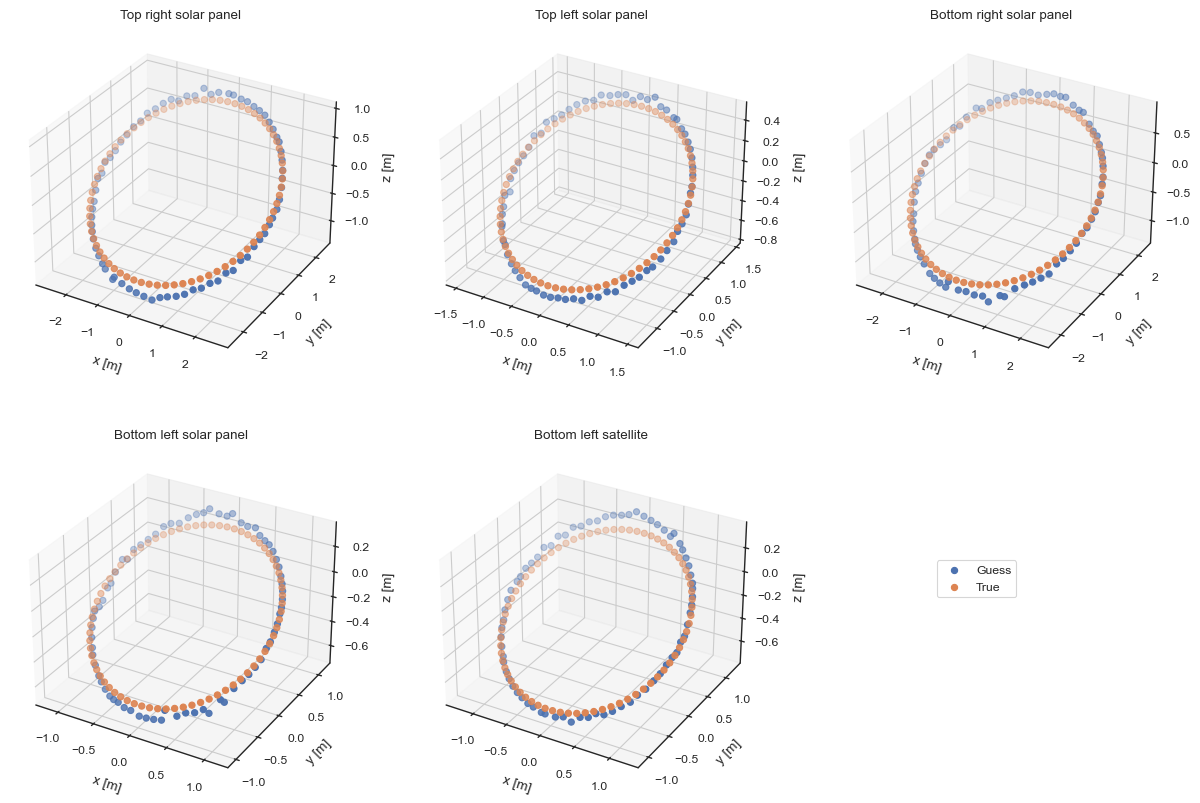

In [712]:
# 3d subplots
fig = plt.figure(figsize=(15, 10))
for i, point in enumerate(three_d_points):
    ax = fig.add_subplot(2, 3, i + 1, projection='3d')
    ax.title.set_text(three_d_points_names[i])
    # labels
    ax.set_xlabel('x [m]')
    ax.set_ylabel('y [m]')
    ax.set_zlabel('z [m]')
    ax.scatter(df_rotated_points[df_rotated_points['3d_point'] == three_d_points_names[i]]['x_point'],
               df_rotated_points[df_rotated_points['3d_point'] == three_d_points_names[i]]['y_point'],
               df_rotated_points[df_rotated_points['3d_point'] == three_d_points_names[i]]['z_point'],
               label=three_d_points_names[i])
    ax.scatter(
        df_rotated_points_true[df_rotated_points_true['3d_point'] == three_d_points_names[i]]['x_point'],
        df_rotated_points_true[df_rotated_points_true['3d_point'] == three_d_points_names[i]]['y_point'],
        df_rotated_points_true[df_rotated_points_true['3d_point'] == three_d_points_names[i]]['z_point'],
        label=three_d_points_names[i] + ' true')

# ax.set_xlabel('x [m]')
# ax.set_ylabel('y [m]')
# ax.set_zlabel('z [m]')
# ax.scatter(df_rotated_points[df_rotated_points['3d_point'] == three_d_points_names[0]]['x'],
#            df_rotated_points[df_rotated_points['3d_point'] == three_d_points_names[0]]['y'],
#            df_rotated_points[df_rotated_points['3d_point'] == three_d_points_names[0]]['z'])

# add legend bottom right in the figure
fig.legend(['Guess', 'True'], loc='lower right', bbox_to_anchor=(0.8, 0.3))
plt.savefig(folder + "/plots/3d_points.png")

In [713]:
df_rotated_points_all = df_rotated_points.merge(df_rotated_points_true, on=['img_number', '3d_point'],
                                                suffixes=('_fine', '_true'))

In [714]:
df_rotated_points_all

,x_point_fine,y_point_fine,z_point_fine,img_number,3d_point,iterations,loss,roll_fine,pitch_fine,yaw_fine,x,y,z,x_point_true,y_point_true,z_point_true,roll_true,pitch_true,yaw_true
0,-0.927040,0.823939,0.117345,1,Bottom left satellite,0,0.058101,162.047951,-68.488490,-80.657160,-0.005982,-0.000509,-0.046545,-0.925096,0.833174,0.045473,163.328561,-72.431496,-82.098936
1,0.947694,0.671556,0.031297,1,Bottom left solar panel,0,0.058101,162.047951,-68.488490,-80.657160,-0.005982,-0.000509,-0.046545,0.950128,0.668834,0.003243,163.328561,-72.431496,-82.098936
2,2.391378,0.456148,-0.062572,1,Bottom right solar panel,0,0.058101,162.047951,-68.488490,-80.657160,-0.005982,-0.000509,-0.046545,2.394214,0.442590,-0.050264,163.328561,-72.431496,-82.098936
3,0.630000,-1.156666,-0.659396,1,Top left solar panel,0,0.058101,162.047951,-68.488490,-80.657160,-0.005982,-0.000509,-0.046545,0.636066,-1.200379,-0.569288,163.328561,-72.431496,-82.098936
4,2.073684,-1.372075,-0.753266,1,Top right solar panel,0,0.058101,162.047951,-68.488490,-80.657160,-0.005982,-0.000509,-0.046545,2.080153,-1.426623,-0.622795,163.328561,-72.431496,-82.098936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,-0.989901,0.746902,0.119504,72,Bottom left satellite,0,0.681237,164.999431,-67.411841,-78.945309,0.003833,-0.006605,-0.115971,-0.991600,0.753907,0.020028,168.680000,-72.540000,-82.470000
356,0.892075,0.741985,0.061256,72,Bottom left solar panel,0,0.681237,164.999431,-67.411841,-78.945309,0.003833,-0.006605,-0.115971,0.891233,0.744893,0.030479,168.680000,-72.540000,-82.470000
357,2.349366,0.641075,-0.013283,72,Bottom right solar panel,0,0.681237,164.999431,-67.411841,-78.945309,0.003833,-0.006605,-0.115971,2.349993,0.638669,0.017477,168.680000,-72.540000,-82.470000
358,0.727692,-1.089330,-0.673354,72,Top left solar panel,0,0.681237,164.999431,-67.411841,-78.945309,0.003833,-0.006605,-0.115971,0.748634,-1.142094,-0.552041,168.680000,-72.540000,-82.470000


In [715]:
def get_signed_angle_distance(angle1, angle2):
    angle1 %= 360
    angle2 %= 360

    difference = (angle1 - angle2) % 360

    if difference > 180:
        return difference - 360
    else:
        return difference

In [716]:
df_rotated_points_all['x_point_fine_pixel'], df_rotated_points_all['y_point_fine_pixel'] = np.vectorize \
    (get_pixel_coordinates)(
    df_rotated_points_all['x_point_fine'], df_rotated_points_all['y_point_fine'], df_rotated_points_all['z_point_fine'])

df_rotated_points_all['x_point_true_pixel'], df_rotated_points_all['y_point_true_pixel'] = np.vectorize \
    (get_pixel_coordinates)(
    df_rotated_points_all['x_point_true'], df_rotated_points_all['y_point_true'], df_rotated_points_all['z_point_true'])

In [717]:
df_rotated_points_all['residual_roll'] = np.vectorize(get_signed_angle_distance)(df_rotated_points_all['roll_fine'],
                                                                                 df_rotated_points_all['roll_true'])
df_rotated_points_all['residual_pitch'] = np.vectorize(get_signed_angle_distance)(df_rotated_points_all['pitch_fine'],
                                                                                  df_rotated_points_all['pitch_true'])
df_rotated_points_all['residual_yaw'] = np.vectorize(get_signed_angle_distance)(df_rotated_points_all['yaw_fine'],
                                                                                df_rotated_points_all['yaw_true'])
df_rotated_points_all['residual_pitch_yaw'] = np.sqrt(df_rotated_points_all['residual_pitch'] ** 2 +
                                                      df_rotated_points_all[
                                                          'residual_yaw'] ** 2)

df_rotated_points_all['residual_x'] = df_rotated_points_all['x_point_fine'] - df_rotated_points_all['x_point_true']
df_rotated_points_all['residual_y'] = df_rotated_points_all['y_point_fine'] - df_rotated_points_all['y_point_true']
df_rotated_points_all['residual_z'] = df_rotated_points_all['z_point_fine'] - df_rotated_points_all['z_point_true']

df_rotated_points_all['residual_x_pixel'] = df_rotated_points_all['x_point_fine_pixel'] - df_rotated_points_all[
    'x_point_true_pixel']
df_rotated_points_all['residual_y_pixel'] = df_rotated_points_all['y_point_fine_pixel'] - df_rotated_points_all[
    'y_point_true_pixel']

In [718]:
df_rotated_points_all

,x_point_fine,y_point_fine,z_point_fine,img_number,3d_point,iterations,loss,roll_fine,pitch_fine,yaw_fine,...,y_point_true_pixel,residual_roll,residual_pitch,residual_yaw,residual_pitch_yaw,residual_x,residual_y,residual_z,residual_x_pixel,residual_y_pixel
0,-0.927040,0.823939,0.117345,1,Bottom left satellite,0,0.058101,162.047951,-68.488490,-80.657160,...,87.891689,-1.280611,3.943006,1.441776,4.198335,-0.001945,-0.009235,0.071872,0.112659,-1.256654
1,0.947694,0.671556,0.031297,1,Bottom left solar panel,0,0.058101,162.047951,-68.488490,-80.657160,...,70.690822,-1.280611,3.943006,1.441776,4.198335,-0.002433,0.002723,0.028054,-0.384748,0.197376
2,2.391378,0.456148,-0.062572,1,Bottom right solar panel,0,0.058101,162.047951,-68.488490,-80.657160,...,46.892596,-1.280611,3.943006,1.441776,4.198335,-0.002836,0.013557,-0.012308,-0.158352,1.463525
3,0.630000,-1.156666,-0.659396,1,Top left solar panel,0,0.058101,162.047951,-68.488490,-80.657160,...,-130.260708,-1.280611,3.943006,1.441776,4.198335,-0.006066,0.043713,-0.090108,-0.369629,4.213617
4,2.073684,-1.372075,-0.753266,1,Top right solar panel,0,0.058101,162.047951,-68.488490,-80.657160,...,-155.199287,-1.280611,3.943006,1.441776,4.198335,-0.006469,0.054548,-0.130470,0.681534,5.017570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,-0.989901,0.746902,0.119504,72,Bottom left satellite,0,0.681237,164.999431,-67.411841,-78.945309,...,79.621719,-3.680569,5.128159,3.524691,6.222658,0.001699,-0.007005,0.099476,0.649596,-1.094589
356,0.892075,0.741985,0.061256,72,Bottom left solar panel,0,0.681237,164.999431,-67.411841,-78.945309,...,78.632415,-3.680569,5.128159,3.524691,6.222658,0.000842,-0.002909,0.030776,-0.042492,-0.416301
357,2.349366,0.641075,-0.013283,72,Bottom right solar panel,0,0.681237,164.999431,-67.411841,-78.945309,...,67.458974,-3.680569,5.128159,3.524691,6.222658,-0.000628,0.002406,-0.030760,0.280850,0.348904
358,0.727692,-1.089330,-0.673354,72,Top left solar panel,0,0.681237,164.999431,-67.411841,-78.945309,...,-123.836103,-3.680569,5.128159,3.524691,6.222658,-0.020942,0.052764,-0.121312,-1.821854,5.049277


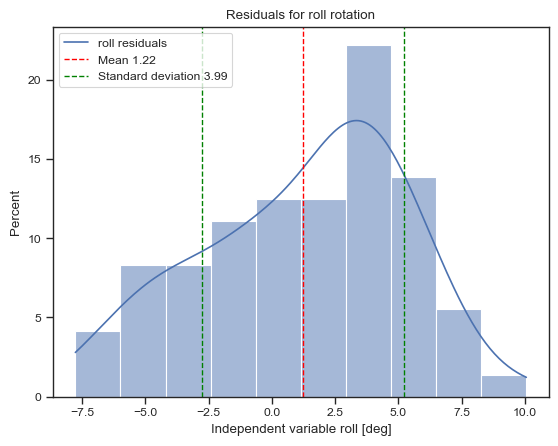

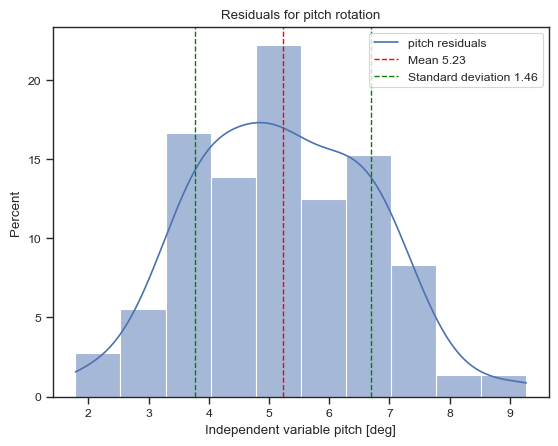

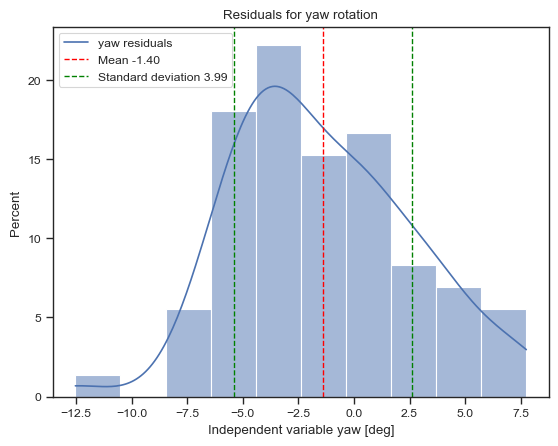

In [719]:
for var in ['roll', 'pitch', 'yaw']:
    g = sns.histplot(data=df_rotated_points_all[df_rotated_points_all['3d_point'] == 'Top right solar panel'],
                     x='residual_' + var,
                     kde=True, stat='percent',
                     bins=10);
    mean = df_rotated_points_all[df_rotated_points_all['3d_point'] == 'Top right solar panel']['residual_' + var].mean()
    std = df_rotated_points_all[df_rotated_points_all['3d_point'] == 'Top right solar panel']['residual_' + var].std()
    plt.axvline(mean, color='red', linestyle='dashed', linewidth=1)
    plt.axvline(mean + std, color='green', linestyle='dashed', linewidth=1)
    plt.axvline(mean - std, color='green', linestyle='dashed', linewidth=1)
    g.legend([var + ' residuals', f"Mean {mean:.2f}", f"Standard deviation {std:.2f}"])
    g.set_title('Residuals for ' + var + ' rotation')
    g.set(xlabel='Independent variable ' + var + ' [deg]')
    plt.savefig(folder + "/plots/" + var + '_residuals.png')
    plt.show()

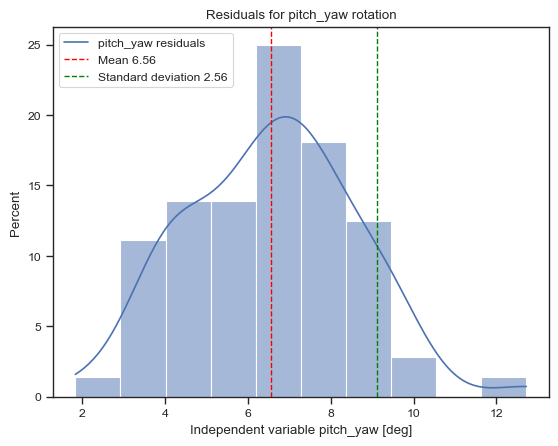

In [720]:
for var in ['pitch_yaw']:
    g = sns.histplot(data=df_rotated_points_all[df_rotated_points_all['3d_point'] == 'Top right solar panel'],
                     x='residual_' + var,
                     kde=True, stat='percent',
                     bins=10);
    mean = df_rotated_points_all[df_rotated_points_all['3d_point'] == 'Top right solar panel']['residual_' + var].mean()
    std = np.sqrt(mean)
    plt.axvline(mean, color='red', linestyle='dashed', linewidth=1)
    plt.axvline(mean + std, color='green', linestyle='dashed', linewidth=1)
    g.legend([var + ' residuals', f"Mean {mean:.2f}", f"Standard deviation {std:.2f}"])
    g.set_title('Residuals for ' + var + ' rotation')
    g.set(xlabel='Independent variable ' + var + ' [deg]')
    plt.savefig(folder + "/plots/" + var + '_residuals.png')
    plt.show()

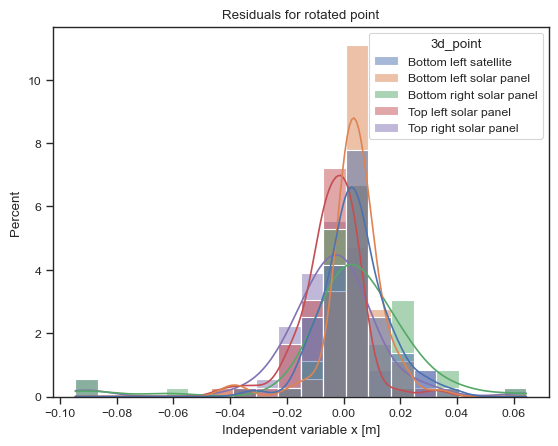

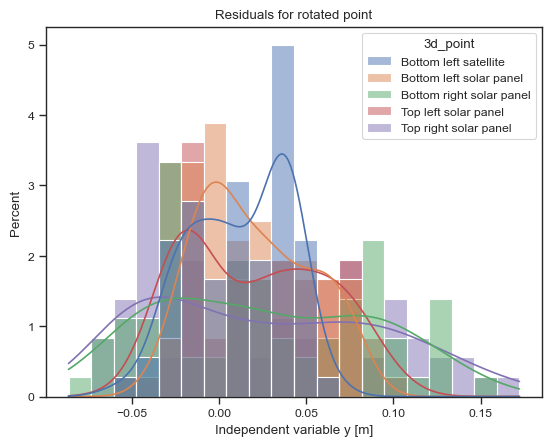

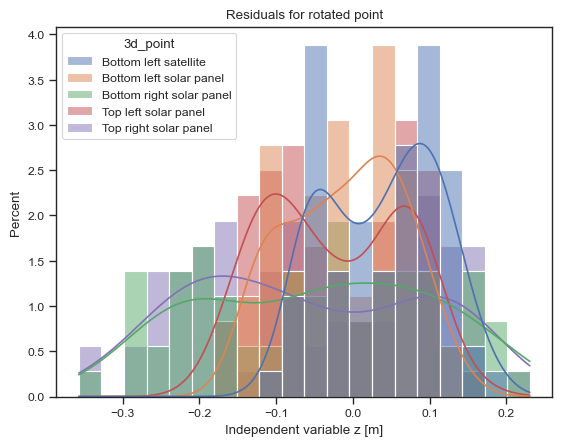

In [721]:
for var in ['x', 'y', 'z']:
    g = sns.histplot(data=df_rotated_points_all,
                     x='residual_' + var,
                     hue='3d_point',
                     kde=True, stat='percent',
                     bins=20);
    g.set_title('Residuals for rotated point')
    g.set(xlabel='Independent variable ' + var + ' [m]')
    plt.savefig(folder + "/plots/" + var + '_residuals' + suffix + '.png')
    plt.show()

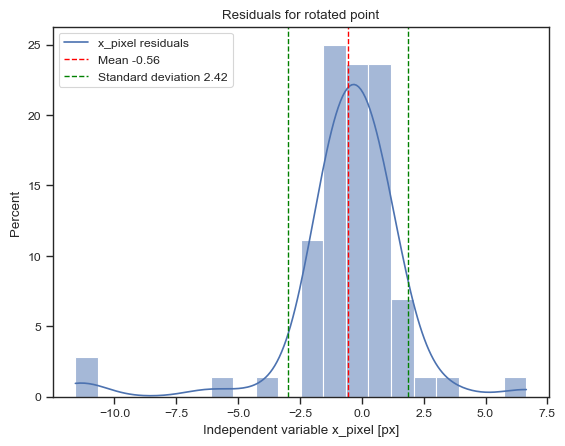

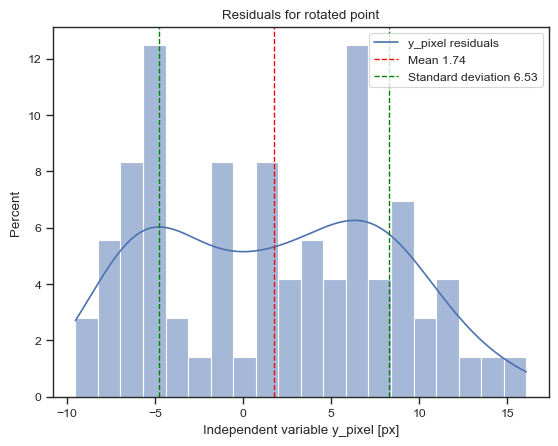

In [722]:
for var in ['x_pixel', 'y_pixel']:
    g = sns.histplot(data=df_rotated_points_all[df_rotated_points_all['3d_point'] == 'Top right solar panel'],
                     x='residual_' + var,
                     hue='3d_point',
                     kde=True, stat='percent',
                     bins=20);
    mean = df_rotated_points_all[df_rotated_points_all['3d_point'] == 'Top right solar panel']['residual_' + var].mean()
    std = df_rotated_points_all[df_rotated_points_all['3d_point'] == 'Top right solar panel']['residual_' + var].std()
    plt.axvline(mean, color='red', linestyle='dashed', linewidth=1)
    plt.axvline(mean + std, color='green', linestyle='dashed', linewidth=1)
    plt.axvline(mean - std, color='green', linestyle='dashed', linewidth=1)
    g.legend([var + ' residuals', f"Mean {mean:.2f}", f"Standard deviation {std:.2f}"])
    g.set_title('Residuals for rotated point')
    g.set(xlabel='Independent variable ' + var + ' [px]')
    plt.savefig(folder + "/plots/" + var + '_residuals' + suffix + '.png')
    plt.show()

In [723]:
for var in ['roll', 'pitch', 'yaw']:
    print(var, (abs(df_rotated_points_all[df_rotated_points_all['3d_point'] == 'Top right solar panel']['residual_' +
                                                                                                        var]
                    / df_rotated_points_all[df_rotated_points_all['3d_point'] == 'Top right solar panel'][
                        var + '_true']) *
                100).mean())



roll 43.200069611671076
pitch 7.370797747838103
yaw 4.088333133916562


In [724]:
df_rotated_points_all

,x_point_fine,y_point_fine,z_point_fine,img_number,3d_point,iterations,loss,roll_fine,pitch_fine,yaw_fine,...,y_point_true_pixel,residual_roll,residual_pitch,residual_yaw,residual_pitch_yaw,residual_x,residual_y,residual_z,residual_x_pixel,residual_y_pixel
0,-0.927040,0.823939,0.117345,1,Bottom left satellite,0,0.058101,162.047951,-68.488490,-80.657160,...,87.891689,-1.280611,3.943006,1.441776,4.198335,-0.001945,-0.009235,0.071872,0.112659,-1.256654
1,0.947694,0.671556,0.031297,1,Bottom left solar panel,0,0.058101,162.047951,-68.488490,-80.657160,...,70.690822,-1.280611,3.943006,1.441776,4.198335,-0.002433,0.002723,0.028054,-0.384748,0.197376
2,2.391378,0.456148,-0.062572,1,Bottom right solar panel,0,0.058101,162.047951,-68.488490,-80.657160,...,46.892596,-1.280611,3.943006,1.441776,4.198335,-0.002836,0.013557,-0.012308,-0.158352,1.463525
3,0.630000,-1.156666,-0.659396,1,Top left solar panel,0,0.058101,162.047951,-68.488490,-80.657160,...,-130.260708,-1.280611,3.943006,1.441776,4.198335,-0.006066,0.043713,-0.090108,-0.369629,4.213617
4,2.073684,-1.372075,-0.753266,1,Top right solar panel,0,0.058101,162.047951,-68.488490,-80.657160,...,-155.199287,-1.280611,3.943006,1.441776,4.198335,-0.006469,0.054548,-0.130470,0.681534,5.017570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,-0.989901,0.746902,0.119504,72,Bottom left satellite,0,0.681237,164.999431,-67.411841,-78.945309,...,79.621719,-3.680569,5.128159,3.524691,6.222658,0.001699,-0.007005,0.099476,0.649596,-1.094589
356,0.892075,0.741985,0.061256,72,Bottom left solar panel,0,0.681237,164.999431,-67.411841,-78.945309,...,78.632415,-3.680569,5.128159,3.524691,6.222658,0.000842,-0.002909,0.030776,-0.042492,-0.416301
357,2.349366,0.641075,-0.013283,72,Bottom right solar panel,0,0.681237,164.999431,-67.411841,-78.945309,...,67.458974,-3.680569,5.128159,3.524691,6.222658,-0.000628,0.002406,-0.030760,0.280850,0.348904
358,0.727692,-1.089330,-0.673354,72,Top left solar panel,0,0.681237,164.999431,-67.411841,-78.945309,...,-123.836103,-3.680569,5.128159,3.524691,6.222658,-0.020942,0.052764,-0.121312,-1.821854,5.049277


In [725]:
for var in ['x', 'y']:
    print(var, (abs(df_rotated_points_all['residual_' + var + '_pixel']
                    / df_rotated_points_all[var + '_point_true_pixel']) *
                100).mean())



x 3.2011515568310958
y 6.858316746540603
